# **Análisis exploratorio de datos**

**Dataset**

➡️  **Nombre:** Lending Club Loan Data (2007–2020) \
➡️  **Fuente:** Kaggle Dataset - Lending Club \
➡️  **Tamaño:** 2'260.701 registros en 151 variables de estudio 

In [83]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency

In [84]:
# Cargar el dataset
file = r"C:\Users\Hp\MACHINE\MINI_PRY_1\data\data_lend.csv"
df = pd.read_csv(file, low_memory=False)
print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (1345310, 40)


📍  Se trabajarán $1'345.310$ de registros que, luego de un proceso de preprocesamiento, se han resumido en $40$ variables de interés.

## **2. Distribución de las variables de estudio**

## 2.1. Variable objetivo

☑️ Variable binaria: ``default``

*   0 = _Fully Paid_
*   1 = _Charged Off_ (default)

In [85]:
# Variables de interés
target = df['default']

In [86]:
# Calcular conteo absoluto y porcentual
abs_counts = target.value_counts()
pct_counts = target.value_counts(normalize=True) * 100
# Combinar en una sola tabla
table = pd.DataFrame({
    'Default': abs_counts.index.map({0: 'Fully Paid', 1: 'Charged Off'}),
    'Count': abs_counts.values,
    'Percentage': pct_counts.values
})
# Formatear porcentaje como string con símbolo %
table['Percentage'] = table['Percentage'].round(2).astype(str) + '%'
table

,Default,Count,Percentage
0,Fully Paid,1076751,80.04%
1,Charged Off,268559,19.96%


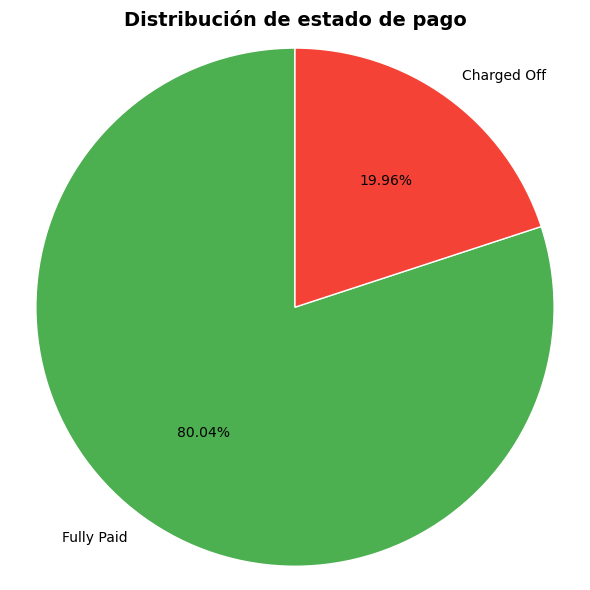

In [87]:
# Extraer datos
labels = table['Default']
sizes = table['Count']
colors = ['#4CAF50', '#F44336']  # Verde para pagado, rojo para impago

# Crear gráfico
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'white'})

# Estilo
plt.title("Distribución de estado de pago", fontsize=14, fontweight="bold")
plt.axis('equal')  # Para que sea perfectamente circular
plt.tight_layout()
plt.show()


La distribución en la variable es 80% - 20%, siendo la mayoría de registros correspondientes a prestamos full pagados.

In [88]:
# Prueba de proporción 
from statsmodels.stats.proportion import proportions_ztest

count = df['default'].sum()        # número de impagos
nobs = df.shape[0]                 # total de observaciones
value = 0.3                       # proporción hipotética

stat, pval = proportions_ztest(count, nobs, value)
print("Prueba de hipótesis para la proporción hipotética del 30% esperado de impagos ")
print("z =", stat, "p-value =", pval)

real_prop = count / nobs
print(f"Proporción observada: {real_prop:.3f}")

Prueba de hipótesis para la proporción hipotética del 30% esperado de impagos 
z = -291.25730076462725 p-value = 0.0
Proporción observada: 0.200


La proporción de impagos observada en los registros es del 20%, mientras que la proporción hipotética planteada fue del 50%.
La diferencia entre ambas proporciones es estadísticamente significativa, como lo indica el p-valor ≈ 0, lo que permite rechazar la hipótesis nula.
El estadístico z negativo confirma que la proporción observada está significativamente por debajo de la proporción hipotética.


## 2.2. Valores faltantes

In [89]:
# Resumen de valores faltantes
# Missing map

# Conteo y porcentaje de nulos
missing = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(2)

# Tabla ordenada
missing_table = pd.DataFrame({
    "Nulos": missing,
    "Porcentaje": missing_percent
})
missing_table = missing_table[missing_table["Nulos"] > 0] \
    .sort_values("Porcentaje", ascending=False)
missing_table

,Nulos,Porcentaje
meses_ultima_consulta,174071,12.94
antiguedad_laboral,78511,5.84
porcentaje_sin_moras,67681,5.03
monto_total_cobranzas,67561,5.02
lineas_credito_12m,67527,5.02
limite_credito_total,67527,5.02
meses_tarjeta_nueva,60221,4.48
cuentas_tarjeta_credito,55841,4.15
cuentas_hipotecarias,47281,3.51
uso_credito_revolvente,857,0.06


Los valores de perdida son bajos, menores al 15%, se realiza la imputación por la mediana o por cero dependiendo la naturaleza de la variable.

In [90]:
# Listado de imputaciones
imputar_cero = ['monto_total_cobranzas', 'lineas_credito_12m', 'cuentas_tarjeta_credito',
                'cuentas_hipotecarias', 'quiebras_publicas', 'cobranzas_12m', 'castigos_12m']
imputar_mediana = ['meses_ultima_consulta', 'antiguedad_laboral','porcentaje_sin_moras',
                   'limite_credito_total', 'meses_tarjeta_nueva', 'uso_credito_revolvente',
                   'dti', 'saldo_revolvente', 'monto_mora']

In [91]:
for col in imputar_cero:
    if col in df.columns:
        df[col] = df[col].fillna(0)

for col in imputar_mediana:
    if col in df.columns:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)

missing_summary = df[imputar_cero + imputar_mediana].isnull().sum()
print(missing_summary[missing_summary > 0])

Series([], dtype: int64)


## 2.3. Correlación de variables 

### Variables numéricas

Correlación de variables, con el método de Spearman bajo el supuesto de no normalidad.

* **Correlación con la variable objetivo**

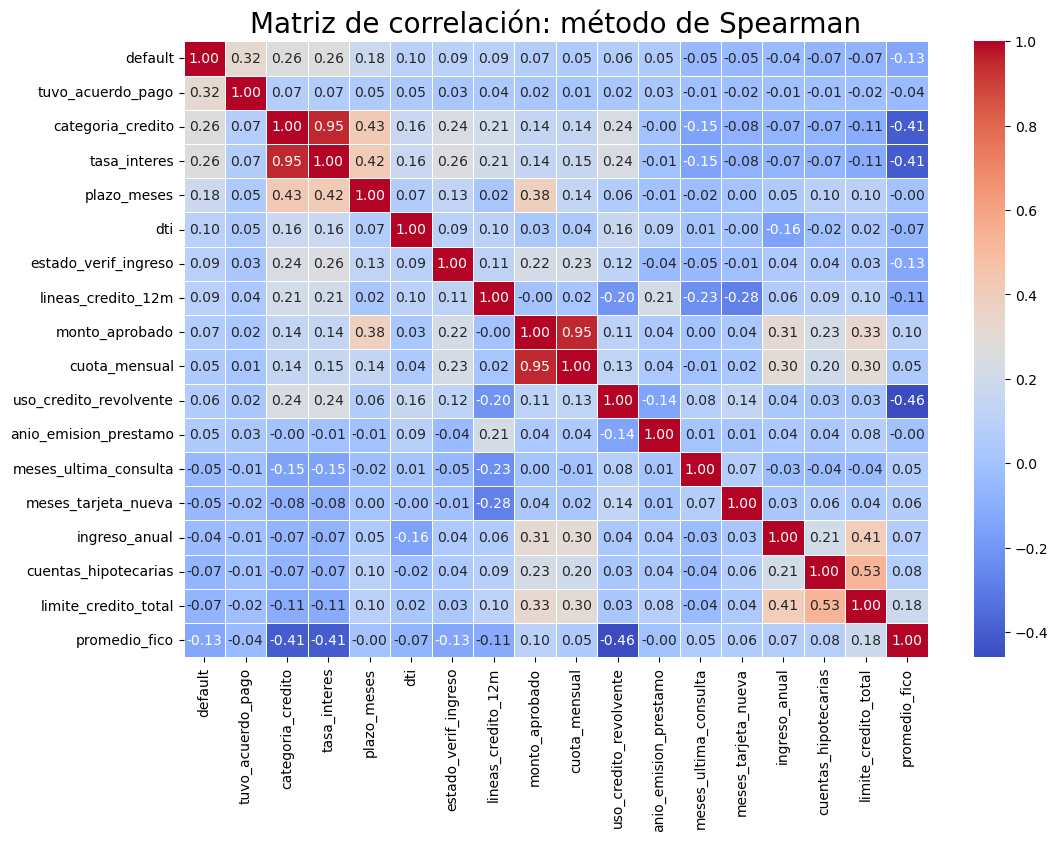

In [92]:
# Correlación de Spearman
corr = df.corr(numeric_only=True, method='spearman')["default"].sort_values(ascending=False)
corr_5= corr[corr.abs() > 0.05]
plt.figure(figsize=(12, 8))
sns.heatmap(df[corr_5.index].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación: método de Spearman', fontsize=20)   
plt.show()

La matriz representa las variables con correlación de Spearman mayor al 5% con la variable objetivo `default`. Se observa que ninguna variable guarda una correlación moderada o fuerte con la objetivo.

* **Variables con alta correlación**\
Se muestran las variables que guardan una correlación mayor al 75% entre ellas.

In [93]:
# Calculamos la matriz de correlación de Spearman
corr_matrix = df.corr(numeric_only=True, method='spearman')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = upper.stack().reset_index()
high_corr.columns = ['Variable1', 'Variable2', 'Spearman_corr']
high_corr = high_corr[high_corr['Spearman_corr'].abs() > 0.75]
high_corr = high_corr.reindex(high_corr['Spearman_corr'].abs().sort_values(ascending=False).index)
print(f"Se encontraron {len(high_corr)} pares de variables con correlación > 75%:\n")
high_corr

Se encontraron 3 pares de variables con correlación > 75%:



,Variable1,Variable2,Spearman_corr
297,monto_aprobado,cuota_mensual,0.969819
371,tasa_interes,categoria_credito,0.956461
6,cuentas_en_mora_actual,monto_mora,0.760041


En el contexto:
* La `cuota_mensual` se calcula a partir del monto aprobado, la tasa de interés y el plazo. Dado que es una función que integra al `monto_aprobado`, se descartará esta variable para modelo. 

* La `tasa_interes` está ligada a la `categoria_credito`, con una posible relación causal. Por tanto se descartará la catergoria del credito al ser una variable categórica, que puede reflejarse dentro de la tasa de interes.

### Variables categóricas

Correlación de variables categóricas, usando prueba de independencia chi cuadrado y método de Cramers.

* **Correlación con la variable objetivo**

In [94]:
# Correlacion objetos - default
def cramers_v(x, y):
    tabla = pd.crosstab(x, y)
    chi2 = chi2_contingency(tabla)[0]
    n = tabla.sum().sum()
    phi2 = chi2 / n
    r, k = tabla.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
resultados = []
for col in df.select_dtypes(include='object'):
    tabla = pd.crosstab(df[col], df['default'])
    chi2, p, _, _ = chi2_contingency(tabla)
    v = cramers_v(df[col], df['default'])
    resultados.append({
        "Variable": col,
        "p-valor": p,
        "Cramér's V": v
    })
tabla_c = pd.DataFrame(resultados)
tabla_c = tabla_c.sort_values(by="Cramér's V", ascending=False)
tabla_c

,Variable,p-valor,Cramér's V
0,tipo_vivienda,0.0,0.070772
1,motivo_prestamo,0.0,0.055415


Para ambos casos, el p-valor de la prueba Chi-Cuadrado es 0.0, lo que significa que las variables están asociadas con la variable objetivo. Pero la fuerza de asociación, descrita por Cramer's V, es débil.

* **Dependencia entre variables categoricas**

In [95]:
# --- Función Cramér's--
def cramers_v(x, y):
    tabla = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(tabla)
    n = tabla.sum().sum()
    phi2 = chi2 / n
    r, k = tabla.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
def association_matrix(df):
    cat_cols = df.select_dtypes(include='object').columns
    results = []
    for i, col1 in enumerate(cat_cols):
        for col2 in cat_cols[i+1:]:
            tabla = pd.crosstab(df[col1], df[col2])
            chi2, p, _, _ = chi2_contingency(tabla)
            v = cramers_v(df[col1], df[col2])
            results.append([col1, col2, f"{p:.2e}", round(v, 3)])
    return pd.DataFrame(results, columns=['Variable 1','Variable 2','P_value','Cramers_v'])
assoc_df = association_matrix(df)
assoc_df

,Variable 1,Variable 2,P_value,Cramers_v
0,tipo_vivienda,motivo_prestamo,0.00e+00,0.086


Las categorías del tipo de vivienda y el motivo de préstamo son dependientes entre sí, pero su fuerza de asociación es débil.

## 2.4 Análisis por grupos

In [96]:
def resumen_num (variable, name):
    resumen = []
    dato = variable
    resumen.append({
            "Variable": name,
            "Mínimo": dato.min(),
            "Máximo": dato.max(),
            "Media": round(dato.mean(),3),
            "Desviación estándar": round(dato.std(),3),
            "25%": dato.quantile(0.25),
            "Mediana": dato.median(),
            "75%": dato.quantile(0.75),
    })
    t_resumen_info = pd.DataFrame(resumen)
    return t_resumen_info

In [97]:
def resumen_categorias(columna, redondeo=2):
    conteo = df[columna].value_counts(dropna=True)
    porcentaje = (conteo / conteo.sum() * 100).round(redondeo)
    resumen = pd.DataFrame({
        'Categoría': conteo.index,
        'Conteo': conteo.values,
        'Porcentaje': porcentaje.values
    })
    return resumen.reset_index(drop=True)

In [98]:
from scipy.stats import shapiro
def normalidad (var):
    datos = df[var]
    print(f"\n Distribución de normalidad para: {datos.name}")
    stat, p = shapiro(datos)
    print(f"    Estadístico: {stat:.4f}, p-valor: {p:.2f}")
    if p > 0.05:
        print(" Distribución normal")
    else:
        print(" Distribución no normal")

#### Información del prestamo

* **Monto aprobado**

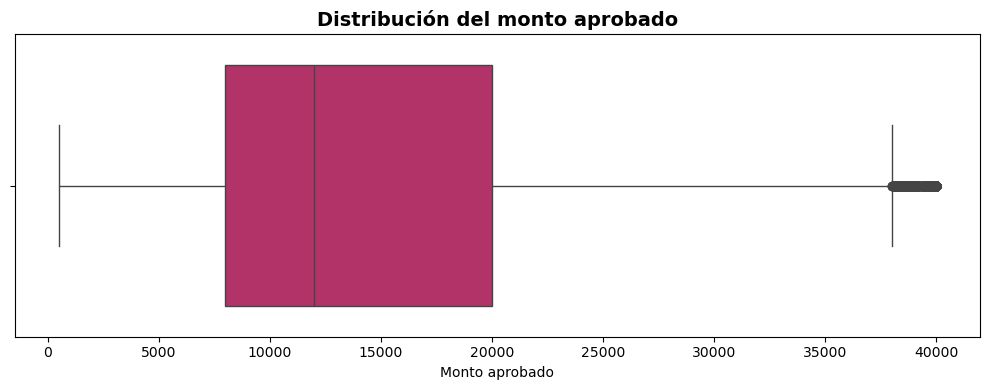

In [99]:
# MONTO APROBADO
plt.figure(figsize=(10,4))
sns.boxplot(x=df['monto_aprobado'], color="#C71E64")

plt.title("Distribución del monto aprobado", fontsize=14, fontweight="bold")
plt.xlabel("Monto aprobado")
plt.tight_layout()
plt.show()

In [100]:
resumen_num(df['monto_aprobado'], 'Monto aprobado')

,Variable,Mínimo,Máximo,Media,Desviación estándar,25%,Mediana,75%
0,Monto aprobado,500.0,40000.0,14411.557,8713.118,8000.0,12000.0,20000.0


In [101]:
normalidad('monto_aprobado')


 Distribución de normalidad para: monto_aprobado
    Estadístico: 0.9373, p-valor: 0.00
 Distribución no normal


El monto aprobado por préstamo varia entre los $500$ a $40,000$ dólares, con un valor medio de $14,411.55$ ($\pm 8,713.11$). La distribución de estos prestamos no sigue una distribución normal, con outlayers luego de los $20,000$ dólares.

* **Tasa de interes**

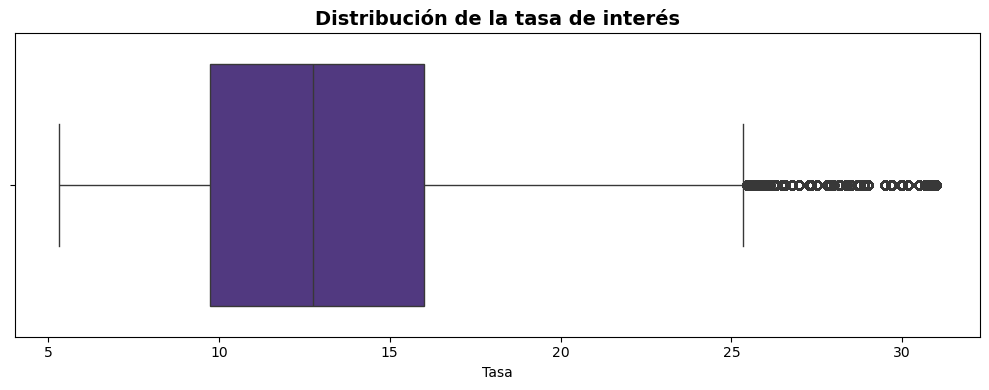

In [102]:
# TASA DE INTERES
plt.figure(figsize=(10,4))
sns.boxplot(x=df['tasa_interes'], color="#4D2D8C")

plt.title("Distribución de la tasa de interés", fontsize=14, fontweight="bold")
plt.xlabel("Tasa")
plt.tight_layout()
plt.show()

In [103]:
resumen_num(df['tasa_interes'], 'Tasa de interes')

,Variable,Mínimo,Máximo,Media,Desviación estándar,25%,Mediana,75%
0,Tasa de interes,5.31,30.99,13.24,4.769,9.75,12.74,15.99


In [104]:
normalidad('tasa_interes')


 Distribución de normalidad para: tasa_interes
    Estadístico: 0.9650, p-valor: 0.00
 Distribución no normal


Para la tasa de interés, el porcentaje varia entre $5.31\%$ a $30.99\%$, con un porcentaje medio de $13.24\%$ ($\pm 4.7\%$). No siguen una distribución normal y existen outlayers después de los $15.99%$.

* **Plazo del préstamo**

In [105]:
# PLAZOS DEL préstamo
binary = {0: '36 months', 1: '60 months'}
df['plazo_meses'] = df['plazo_meses'].map(binary)

plazo_counts = df["plazo_meses"].value_counts().reset_index()
plazo_counts.columns = ["Plazo", "Cantidad"]

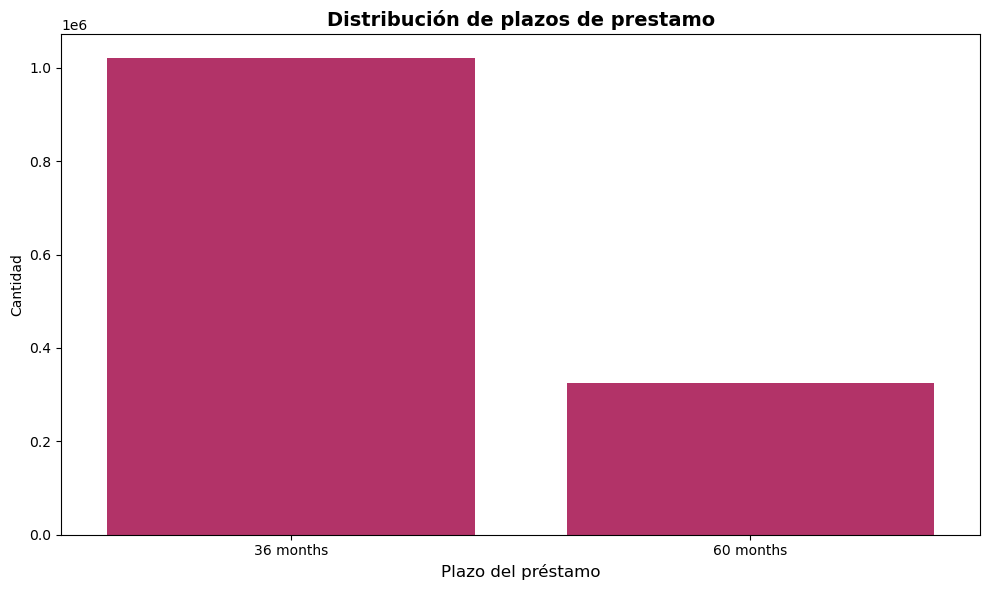

In [106]:
# Gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=plazo_counts, x="Plazo", y="Cantidad", color="#C71E64")

plt.title("Distribución de plazos de prestamo", fontsize=14, fontweight="bold")
plt.xlabel("Plazo del préstamo", fontsize=12)
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

In [107]:
resumen_categorias('plazo_meses')

,Categoría,Conteo,Porcentaje
0,36 months,1020743,75.87
1,60 months,324567,24.13


Los prestamos otorgados se han dado en su mayoría ($75.87\%$) son otorgados para 36 meses. Solo $324,567$ préstamos fueron otorgados para un plazo de 60 meses.

* **Motivo del préstamo**

In [108]:
categories ={
        "debt_consolidation": "Consolidación de deudas",
        "small_business": "Negocio pequeño",
        "home_improvement": "Mejora de vivienda",
        "major_purchase": "Compra mayor",
        "credit_card": "Tarjeta de crédito",
        "other": "Otro",
        "house": "Comprar una casa",
        "vacation": "Vacaciones",
        "car": "Compra de un auto",
        "medical": "Gastos médicos",
        "moving": "Mudanza",
        "renewable_energy": "Energía renovable",
        "wedding": "Boda",
        "educational": "Educación"
    }
df['motivo_préstamo'] = df['motivo_prestamo'].map(categories)

motivo_counts = df["motivo_prestamo"].value_counts().reset_index()
motivo_counts.columns = ["Motivo", "Cantidad"]

conteo_purpose = df['motivo_prestamo'].value_counts()

top2 = conteo_purpose.head(2)
resto = conteo_purpose.iloc[2:]

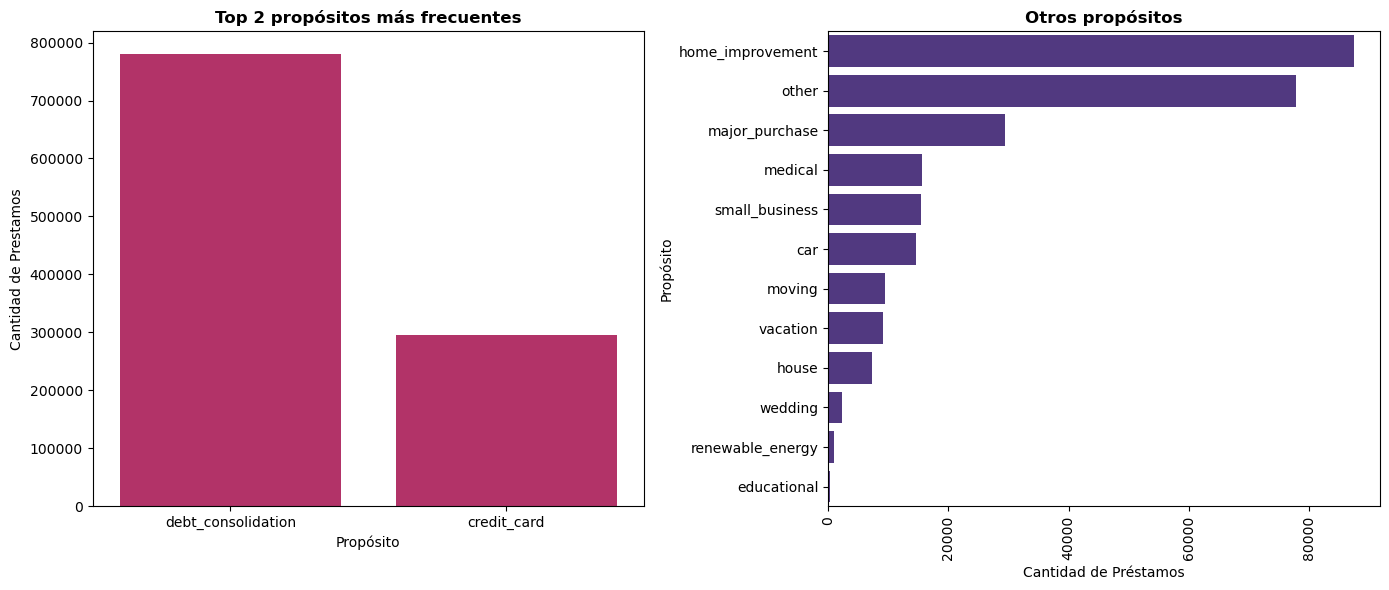

In [109]:
# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

# Gráfico top 2
sns.barplot(x=top2.index, y=top2.values, color="#C71E64", ax=axes[0])
axes[0].set_title("Top 2 propósitos más frecuentes", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Propósito")
axes[0].set_ylabel("Cantidad de Prestamos")
axes[0].tick_params(axis='x', rotation=0)

# Gráfico resto
sns.barplot(y=resto.index, x=resto.values, color="#4D2D8C", ax=axes[1])
axes[1].set_title("Otros propósitos", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Propósito")
axes[1].set_xlabel("Cantidad de Préstamos")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [110]:
resumen_categorias('motivo_prestamo').head(5)

,Categoría,Conteo,Porcentaje
0,debt_consolidation,780321,58.00
1,credit_card,295279,21.95
2,home_improvement,87504,6.50
3,other,77875,5.79
4,major_purchase,29425,2.19


La mayoría de los propósitos para los prestamos otorgados fueron para consolidación de deudas ($59\%$) o por concepto tarjeta de crédito ($21.95\%$).
 

#### Información del prestatario

* **Ingreso anual**

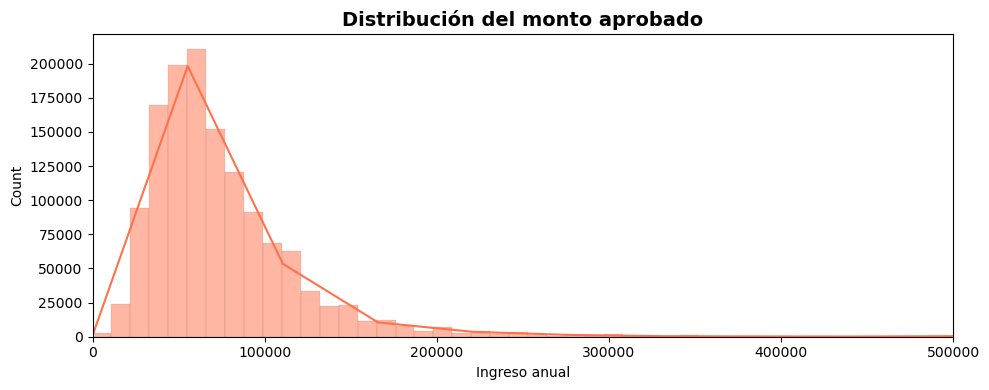

In [111]:
# INGRESO ANUAL
plt.figure(figsize=(10,4))
sns.histplot(x=df['ingreso_anual'], bins=1000, kde = True, color="#FF714B")

plt.title("Distribución del monto aprobado", fontsize=14, fontweight="bold")
plt.xlabel("Ingreso anual")
plt.xlim(0,500000)
plt.tight_layout()
plt.show()

In [112]:
resumen_num(df.loc[df['ingreso_anual'] < 500000, 'ingreso_anual'], 'Ingresos anuales < 500K')

,Variable,Mínimo,Máximo,Media,Desviación estándar,25%,Mediana,75%
0,Ingresos anuales < 500K,0.0,499992.0,74929.453,45090.023,45696.0,65000.0,90000.0


In [113]:
normalidad('ingreso_anual')


 Distribución de normalidad para: ingreso_anual
    Estadístico: 0.4072, p-valor: 0.00
 Distribución no normal


El ingreso anual de los prestatarios, no sigue una distribución normal, con un valor medio de $74,923$ dólares. Con valores atípicos de prestatarios con ingresos mayores a los $200,000$.

* **Tipo de vivienda**

In [114]:
vivienda = {'OWN': 'Propietario','MORTGAGE': 'Hipoteca','RENT': 'Alquiler','OTHER': 'Otro','ANY': 'Cualquiera','NONE': 'Ninguno'}
df['tipo_vivienda'] = df['tipo_vivienda'].map(vivienda)

vivi_counts = df["tipo_vivienda"].value_counts().reset_index()
vivi_counts.columns = ["Tipo de vivienda", "Cantidad"]

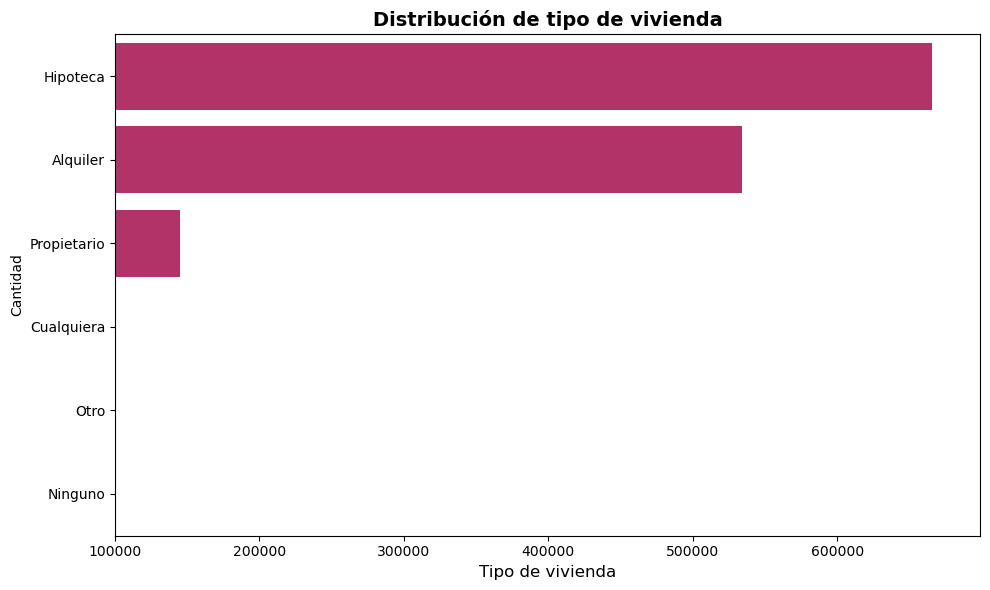

In [115]:
plt.figure(figsize=(10,6))
sns.barplot(data=vivi_counts, y="Tipo de vivienda", x="Cantidad", color="#C71E64")

plt.title("Distribución de tipo de vivienda", fontsize=14, fontweight="bold")
plt.xlabel("Tipo de vivienda", fontsize=12)
plt.ylabel("Cantidad")
plt.xlim(100000,)
plt.tight_layout()
plt.show()

In [116]:
resumen_categorias('tipo_vivienda').head(5)

,Categoría,Conteo,Porcentaje
0,Hipoteca,665579,49.47
1,Alquiler,534421,39.72
2,Propietario,144832,10.77
3,Cualquiera,286,0.02
4,Otro,144,0.01


De los prestatarios, en su mayoría tienen una casa con hipoteca ($49.47\%$) o en alquiler ($39.72\%$), solo un $10.77\%$ es propietario de su propia casa. 

#### Historial crediticio

* **Promedio FICO**

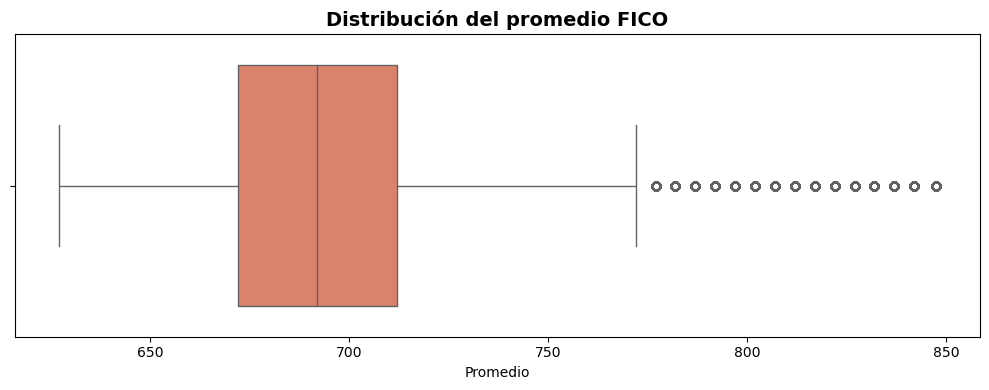

In [117]:
#PROMEDIO_FICO
plt.figure(figsize=(10,4))
sns.boxplot(x=df['promedio_fico'], color="#ED775A")

plt.title("Distribución del promedio FICO", fontsize=14, fontweight="bold")
plt.xlabel("Promedio")
plt.tight_layout()
plt.show()

In [118]:
resumen_num(df['promedio_fico'], 'Promedio_FICO')

,Variable,Mínimo,Máximo,Media,Desviación estándar,25%,Mediana,75%
0,Promedio_FICO,627.0,847.5,698.185,31.853,672.0,692.0,712.0


In [119]:
normalidad('promedio_fico')


 Distribución de normalidad para: promedio_fico
    Estadístico: 0.8881, p-valor: 0.00
 Distribución no normal


El promedio FICO de los prestatarios, varia entre los 627 a los 847 puntos.

* **Total de cuentas de crédito**

In [120]:
credit = df["total_cuentas_credito"].dropna().astype(int)  # quitamos nulos si los hay
n = len(credit)
k_sturges = int(1 + np.log2(n))
# Rango de años
R = credit.max() - credit.min()
# Amplitud de clase
h = int(np.ceil(R / k_sturges))
# --- Crear límites de intervalos ---
min_year = credit.min()
max_year = credit.max()

# Creamos los intervalos
# Construimos bordes de clase
bins = list(range(min_year, max_year + h, h))

# Tabla de frecuencia agrupada
tabla = pd.cut(credit, bins=bins, right=False).value_counts().sort_index()

tabla_frec = pd.DataFrame({
    "Intervalo": [f"[{int(interval.left)}, {int(interval.right)})" for interval in tabla.index],
    "Frecuencia": tabla.values,
})
tabla_frec.head(10)


,Intervalo,Frecuencia
0,"[2, 11)",113302
1,"[11, 20)",378651
2,"[20, 29)",404946
3,"[29, 38)",256281
4,"[38, 47)",119720
5,"[47, 56)",46974
6,"[56, 65)",18050
7,"[65, 74)",4699
8,"[74, 83)",1611
9,"[83, 92)",657


La mayoría de prestatarios tiene entre 20 - 29 cuentas de crédito. 

#### Morosidad

In [121]:
acuerdo = {0: 'No tuvo', 1: 'Tuvo'}
df['tuvo_acuerdo_pago'] = df['tuvo_acuerdo_pago'].map(acuerdo)

acu_counts = df['tuvo_acuerdo_pago'].value_counts().reset_index()
acu_counts.columns = ["Acuerdo de pago", "Cantidad"]

In [122]:
resumen_categorias('tuvo_acuerdo_pago')

,Categoría,Conteo,Porcentaje
0,No tuvo,1312034,97.53
1,Tuvo,33276,2.47


Solo el $2.47\%$ tuvo que requerir un acuerdo de pago para su prestamo.

#### **Técnicas de control**

* **Distribución de la categoría del crédito**

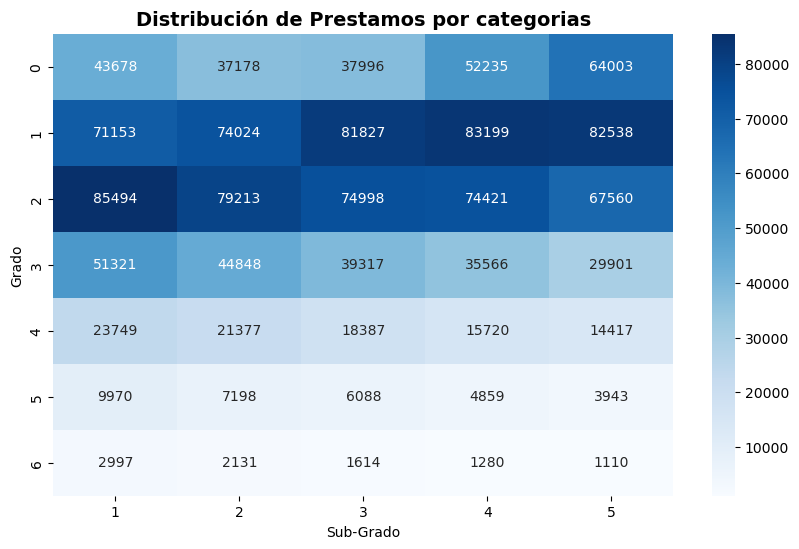

In [123]:
# Crear tabla cruzada de frecuencia
tabla_g = pd.crosstab(df['categoria_credito'], df['subcategoria_credito'])

# Graficar heatmap
plt.figure(figsize=(10,6))
sns.heatmap(tabla_g, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.title("Distribución de Prestamos por categorias", fontsize=14, fontweight="bold")
plt.xlabel("Sub-Grado")
plt.ylabel("Grado")
plt.show()


En su mayoría los prestamos otorgados son de categoría B o C, y en menor medida de categoría G. 

* **Distribución del año - meses de emisión del préstamo**

In [124]:
years = df["anio_emision_prestamo"].dropna().astype(int)  # quitamos nulos si los hay
n = len(years)
k_sturges = int(1 + np.log2(n))
# Rango de años
R = years.max() - years.min()
# Amplitud de clase
h = int(np.ceil(R / k_sturges))
# --- Crear límites de intervalos ---
min_year = years.min()
max_year = years.max()

# Creamos los intervalos
# Construimos bordes de clase
bins = list(range(min_year, max_year + h, h))

# Tabla de frecuencia agrupada
tabla = pd.cut(years, bins=bins, right=False).value_counts().sort_index()

tabla_frec = pd.DataFrame({
    "Intervalo": [f"[{int(interval.left)}, {int(interval.right)})" for interval in tabla.index],
    "Frecuencia": tabla.values,
})

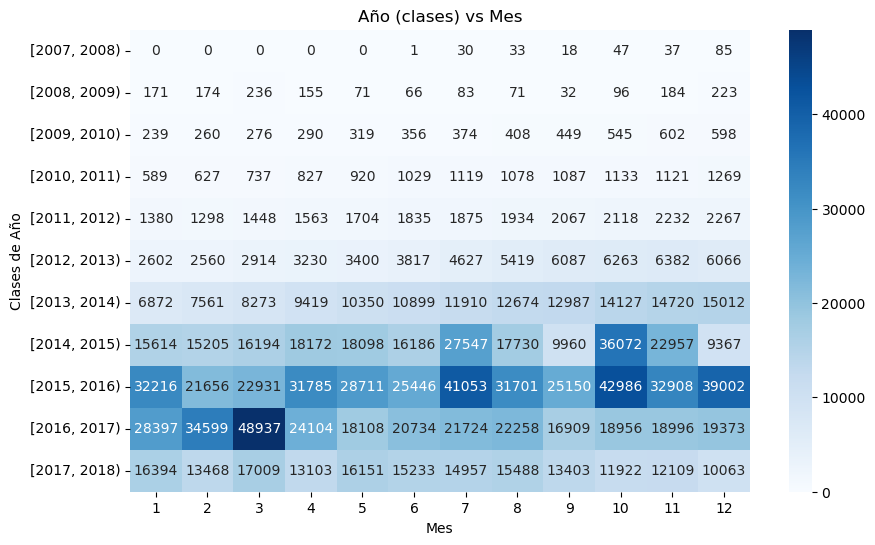

In [125]:
df["year_class"] = pd.cut(df["anio_emision_prestamo"], bins=bins, right=False)

# --- 2. Agrupar por clase y mes ---
tabla = pd.crosstab(df["year_class"], df["mes_emision_prestamo"])

# --- 3. Graficar heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(tabla, annot=True, fmt="d", cmap="Blues")
plt.title("Año (clases) vs Mes")
plt.xlabel("Mes")
plt.ylabel("Clases de Año")
plt.show()

En su mayoría los prestamos fueron otorgados entre el 2015. El mes con mayor cantidad de prestamos fue marzo en el periodo 2016 ($489,937$).